# Testing Clustering Algorithms

In [ ]:
# Packages used for developing models, as well as processing information

from IPython import get_ipython
from IPython.display import display
# %%
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
filterwarnings('ignore')

In [ ]:

#Reading the database and checking some information
#I purposely eliminated some information from the data set so that I could apply methods to fill
#in empty fields and transform text data into numeric values.

Dataset = pd.read_csv('breast_cancer.csv',sep=';', on_bad_lines='skip')
Dataset.info()
Dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              565 non-null    float64
 1   mean texture             566 non-null    float64
 2   mean perimeter           566 non-null    float64
 3   mean area                568 non-null    float64
 4   mean smoothness          566 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,565.000000,566.000000,566.000000,568.000000,566.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,711.656867,19.291343,91.869399,654.637500,0.096259,0.104341,0.088799,0.048919,0.181162,0.062798,...,315.194921,25.677223,107.261213,880.583128,0.132369,2.111808,4.410401,0.114606,0.290076,0.083946
std,2438.148614,4.309063,24.290511,352.173096,0.013926,0.052813,0.079720,0.038803,0.027414,0.007060,...,1655.459336,6.146258,33.602542,569.356993,0.022832,44.343334,69.928599,0.065732,0.061867,0.018061
min,7.760000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,12.200000,16.172500,75.065000,420.175000,0.086380,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.180000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.850000,18.835000,86.140000,548.750000,0.095865,0.092630,0.061540,0.033500,0.179200,0.061540,...,15.150000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,17.600000,21.807500,104.025000,782.625000,0.105250,0.130400,0.130700,0.074000,0.195700,0.066120,...,19.850000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9904.000000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,9981.000000,49.540000,251.200000,4254.000000,0.222600,1058.000000,1252.000000,0.291000,0.663800,0.207500


# Checking Some Measurements



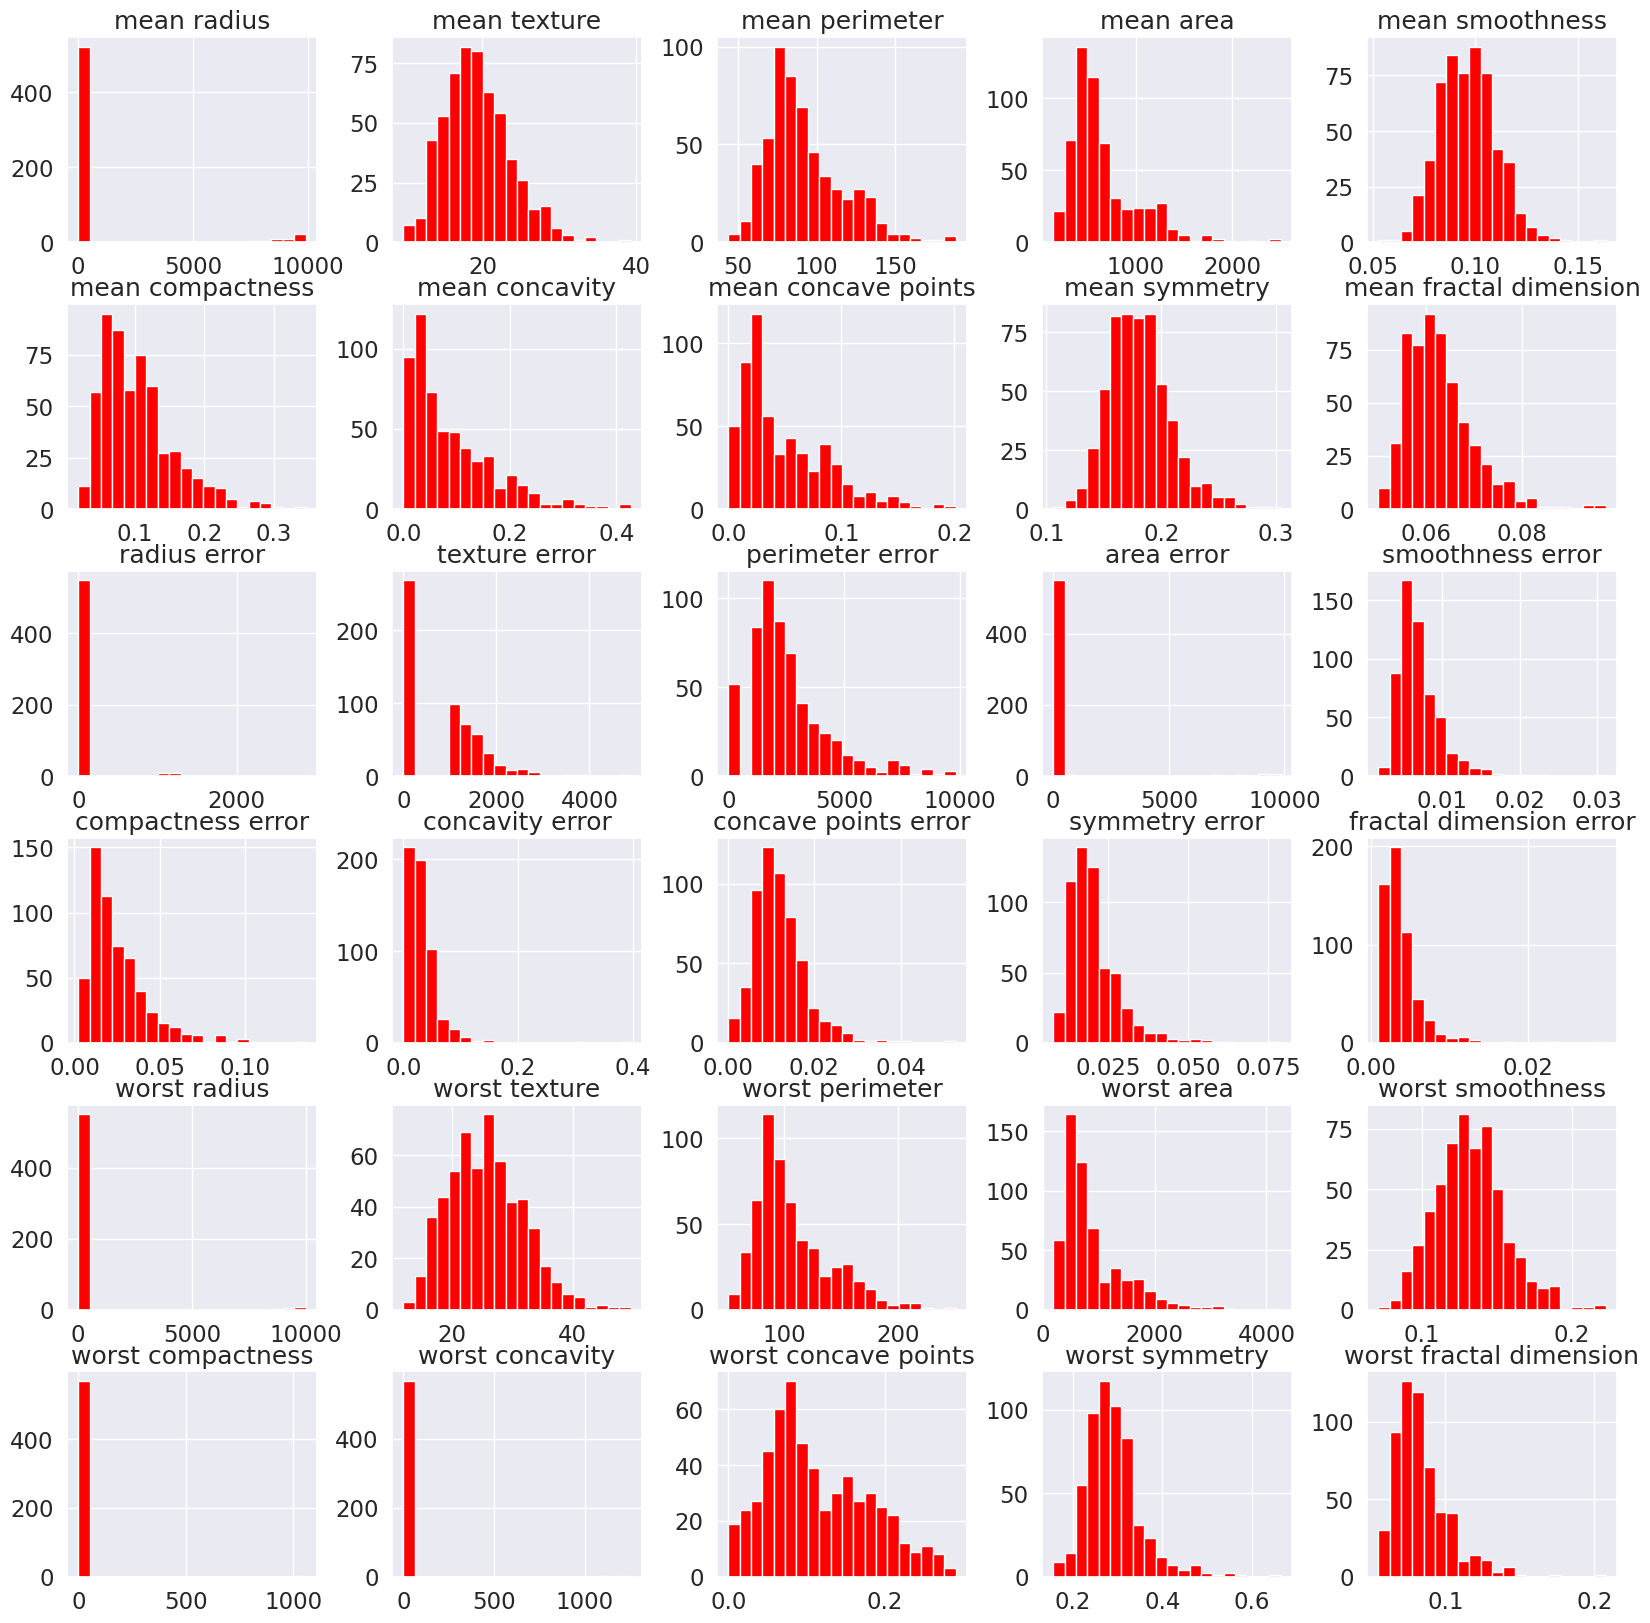

In [ ]:
sns.set(font_scale=1.5,rc={'figure.figsize':(20,20)}) #usando a biblioteca sns posso verificar algumas distribuições dos meus dados
eixo=Dataset.hist(bins=20,color='red')

<Axes: >

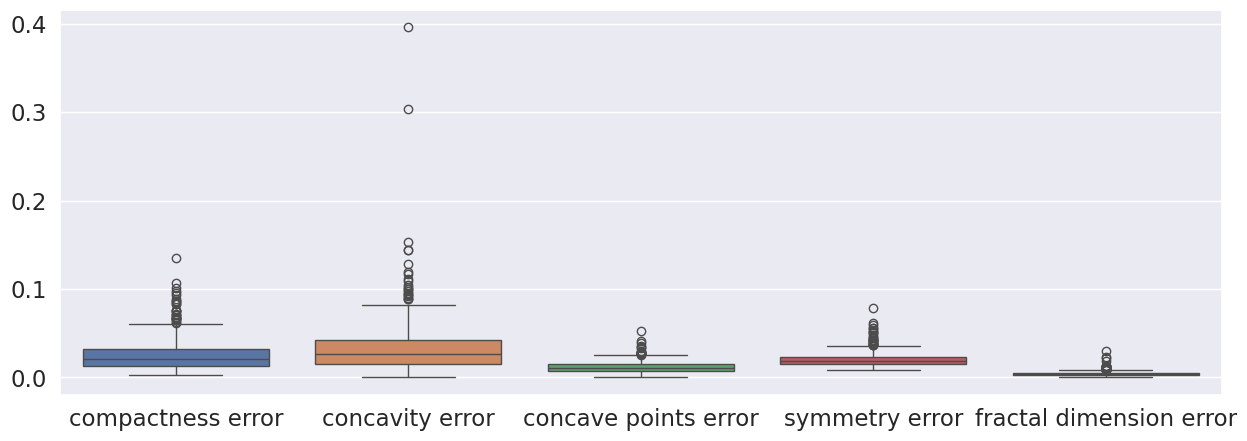

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=Dataset.iloc[:, 15:20])

# Processing Some Variables

In [ ]:
# select objetc columns and transform into float values
textos =Dataset.select_dtypes(include=['object']).columns
for column in textos:
  if column not in ['target','Family Case']:
    Dataset[column] = Dataset[column].str.replace(',', '.').astype(float)
Dataset.select_dtypes(include=['object']).columns

Index(['Family Case', 'target'], dtype='object')

In [ ]:


#my target variable is a text, so to use it in my model I select the information and assign 1 to a case and 0 to the negative of my case
a=Dataset.columns[Dataset.isna().any()].tolist()
b=Dataset.columns
c=list(Dataset.select_dtypes(include=['object']).columns)
c.remove('target')
d=Dataset.columns

X = Dataset.iloc[:,:-1].values
y = Dataset.iloc[:,-1].values

# Instead of using 'target' as a string index, get the index of the 'target' column
target_index = Dataset.columns.get_loc('target')

info_target=[]
# Access the column data using the target_index
col_data = pd.Series(y)
for elemento in list(col_data.unique()):
    info_target.append(elemento)

for k in range(0,len(col_data)):
  if col_data[k]==info_target[0]:
    col_data[k]=0
  else:
    col_data[k]=1
y = col_data.values

In [ ]:
#In this step I select my data set and transform other text variables into numeric ones to facilitate the processing of my model.
ids=[]
for k in range(0,len(b)):
   if b[k] in a:
    ids.append(k)
#Include mean in spots without values, I can use other types of methods.
if ids !=[]:
  imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
  imputer= imputer.fit(X[:,ids])
  X[:,ids]=imputer.transform(X[:,ids])


Lista_variaveis=[]
Lista_dummies=[]

objetos =[]
variavel_final=[]
for k in range(0,len(b)):
   if b[k] in c:
    objetos.append(k)

if objetos!=[]:
    # Convert X to a DataFrame for easier manipulation
    X_df = pd.DataFrame(X, columns=Dataset.columns[:-1])

    # Perform one-hot encoding using Pandas get_dummies
    for col_index in objetos:
        dummy_df = pd.get_dummies(X_df.iloc[:, col_index], prefix=Dataset.columns[col_index], dtype='int')
        X_df = pd.concat([X_df, dummy_df], axis=1)
        Lista_dummies.extend(dummy_df.columns)  # Add dummy column names

    # Drop original categorical columns
    X_df = X_df.drop(columns=Dataset.columns[objetos])

    # Update Lista_variaveis with dummy columns and remaining features
    Lista_variaveis = list(X_df.columns[~X_df.columns.isin(Lista_dummies)]) +Lista_dummies
    #Lista_variaveis = list(X_df.columns)
    # Convert back to NumPy array if needed
    X = X_df.values

X =pd.DataFrame(data=X, columns=Lista_variaveis)
#min_max_scaler =MinMaxScaler()
#X = min_max_scaler.fit_transform(X)
X= StandardScaler().fit_transform(X)


# Checking Some Measurements (Pt2)

<Axes: >

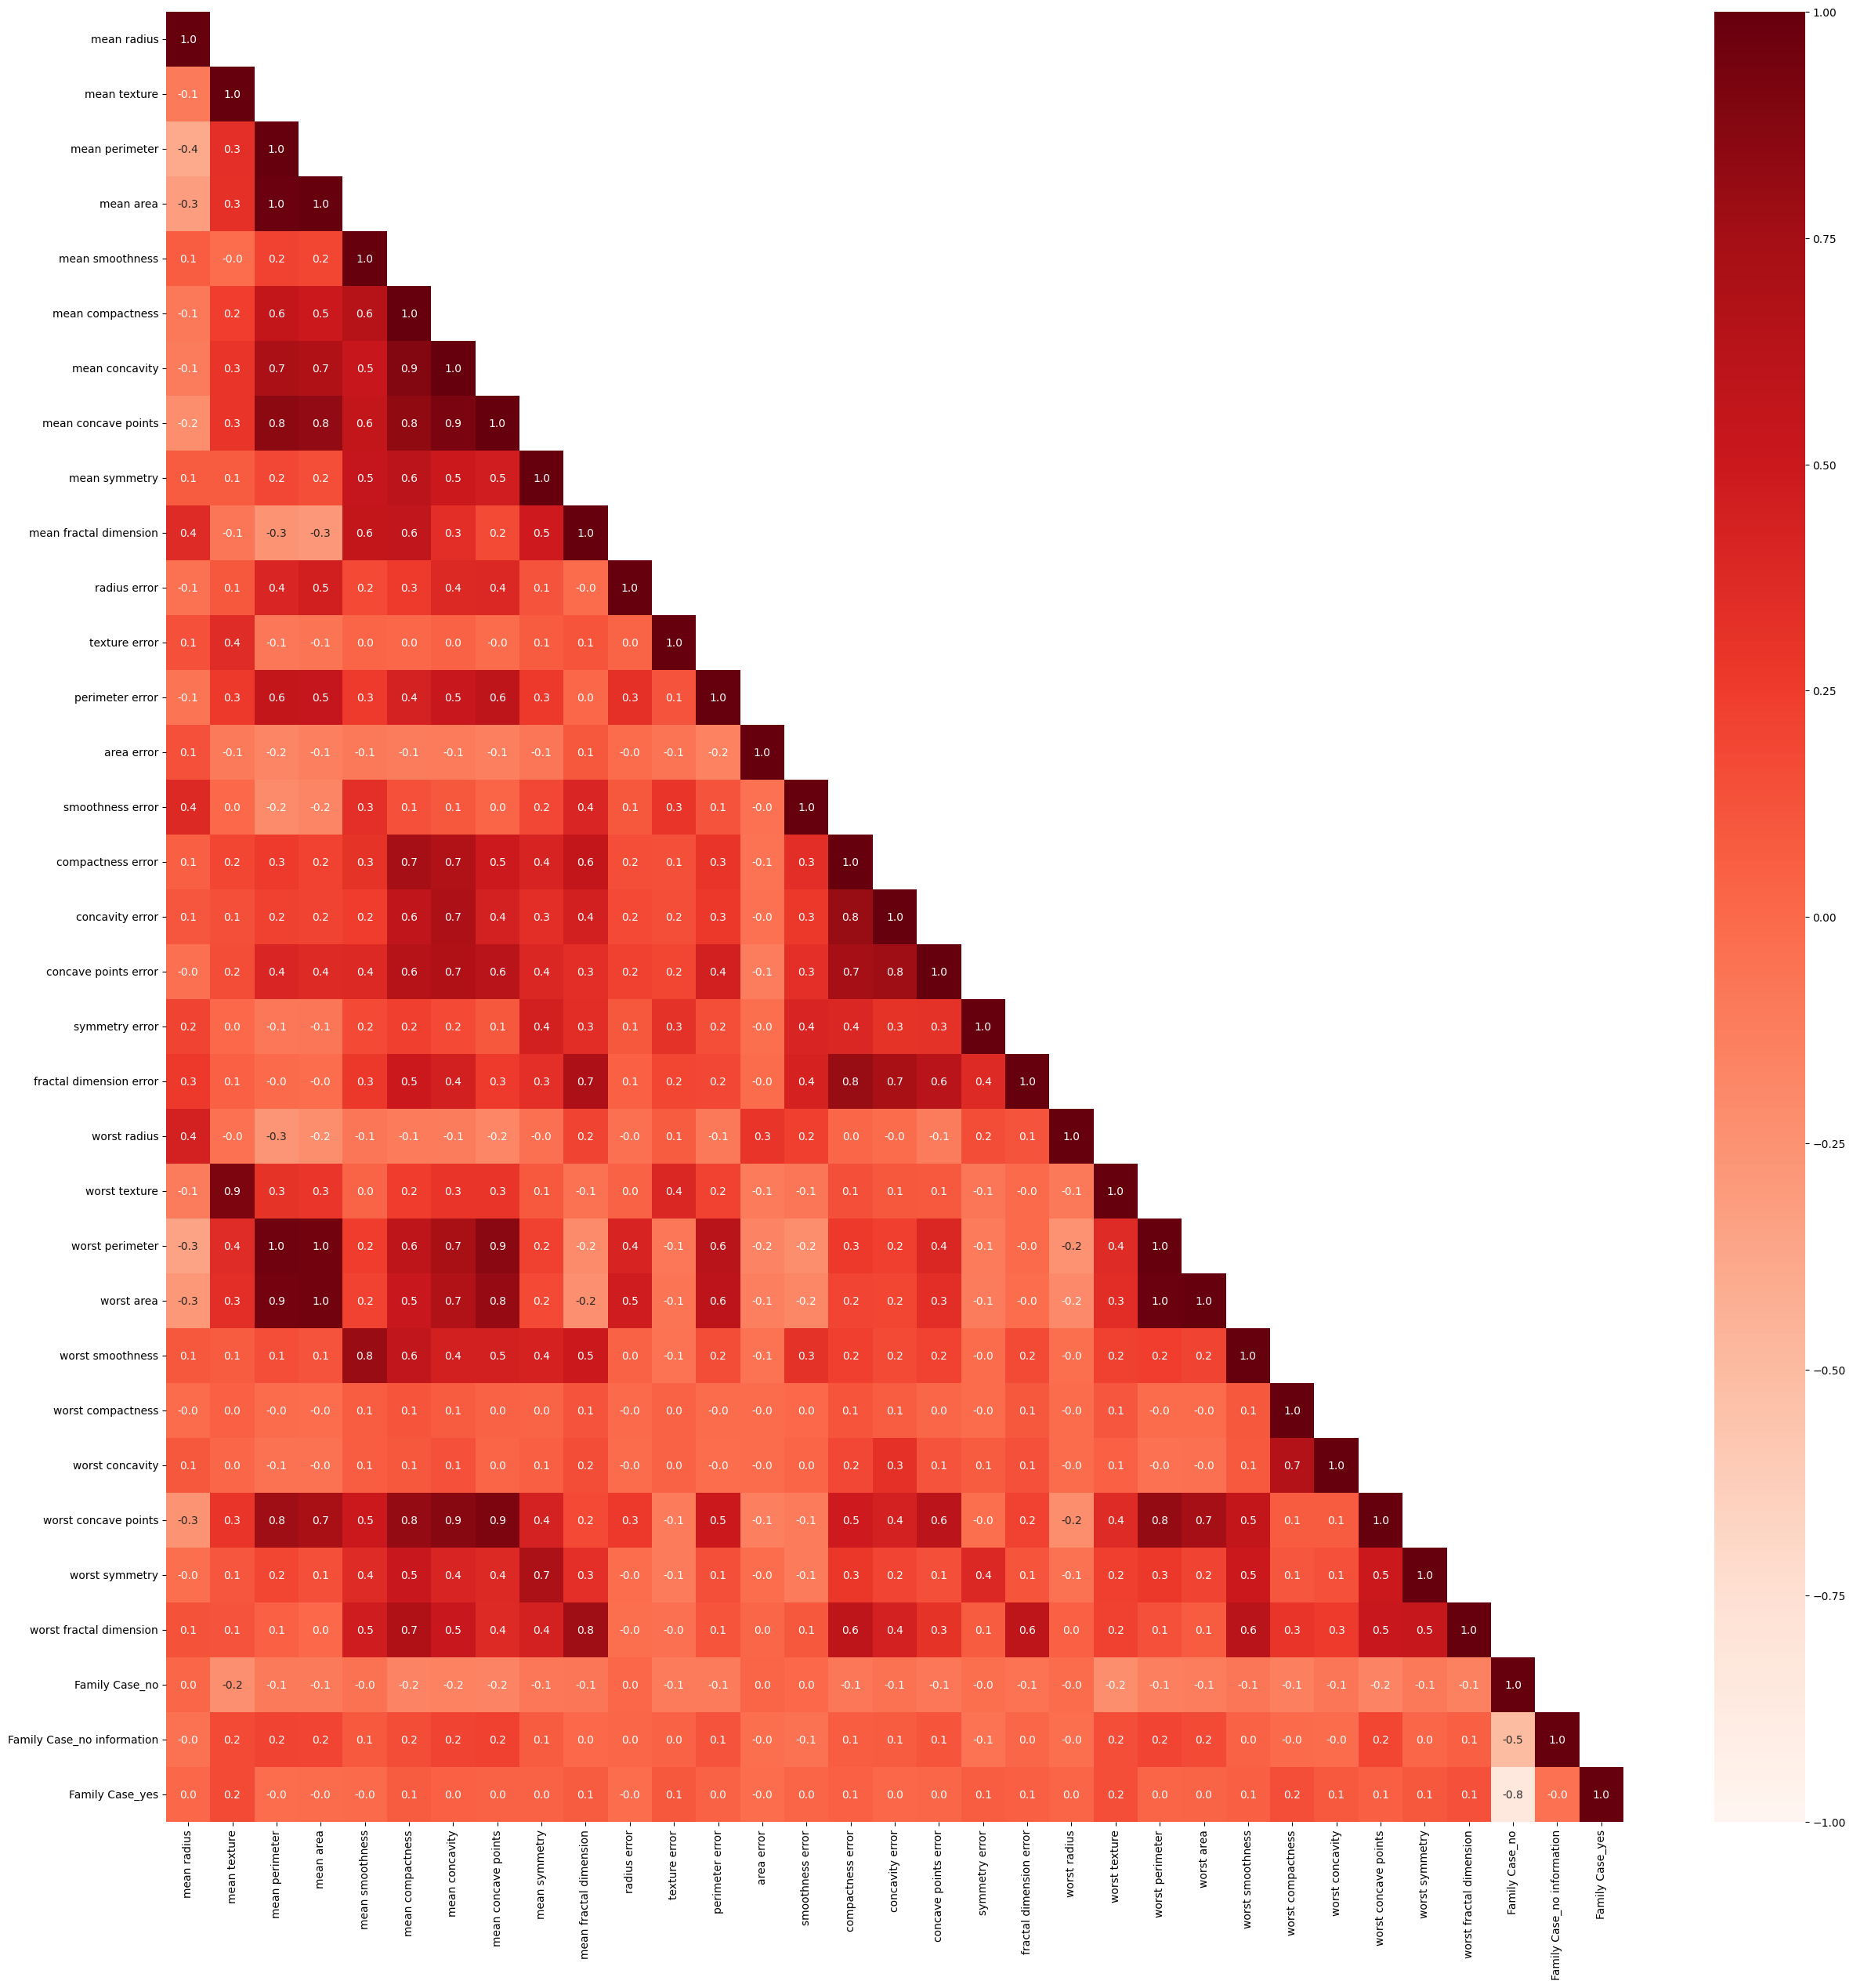

In [ ]:
#X=X.values
# Create correlation matrix
corr_mat = X_df.corr()

# Create mask
mask = np.zeros_like(corr_mat, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mat, annot=True, fmt='.1f',
            cmap='Reds', vmin=-1, vmax=1,
            mask=mask)

<Axes: >

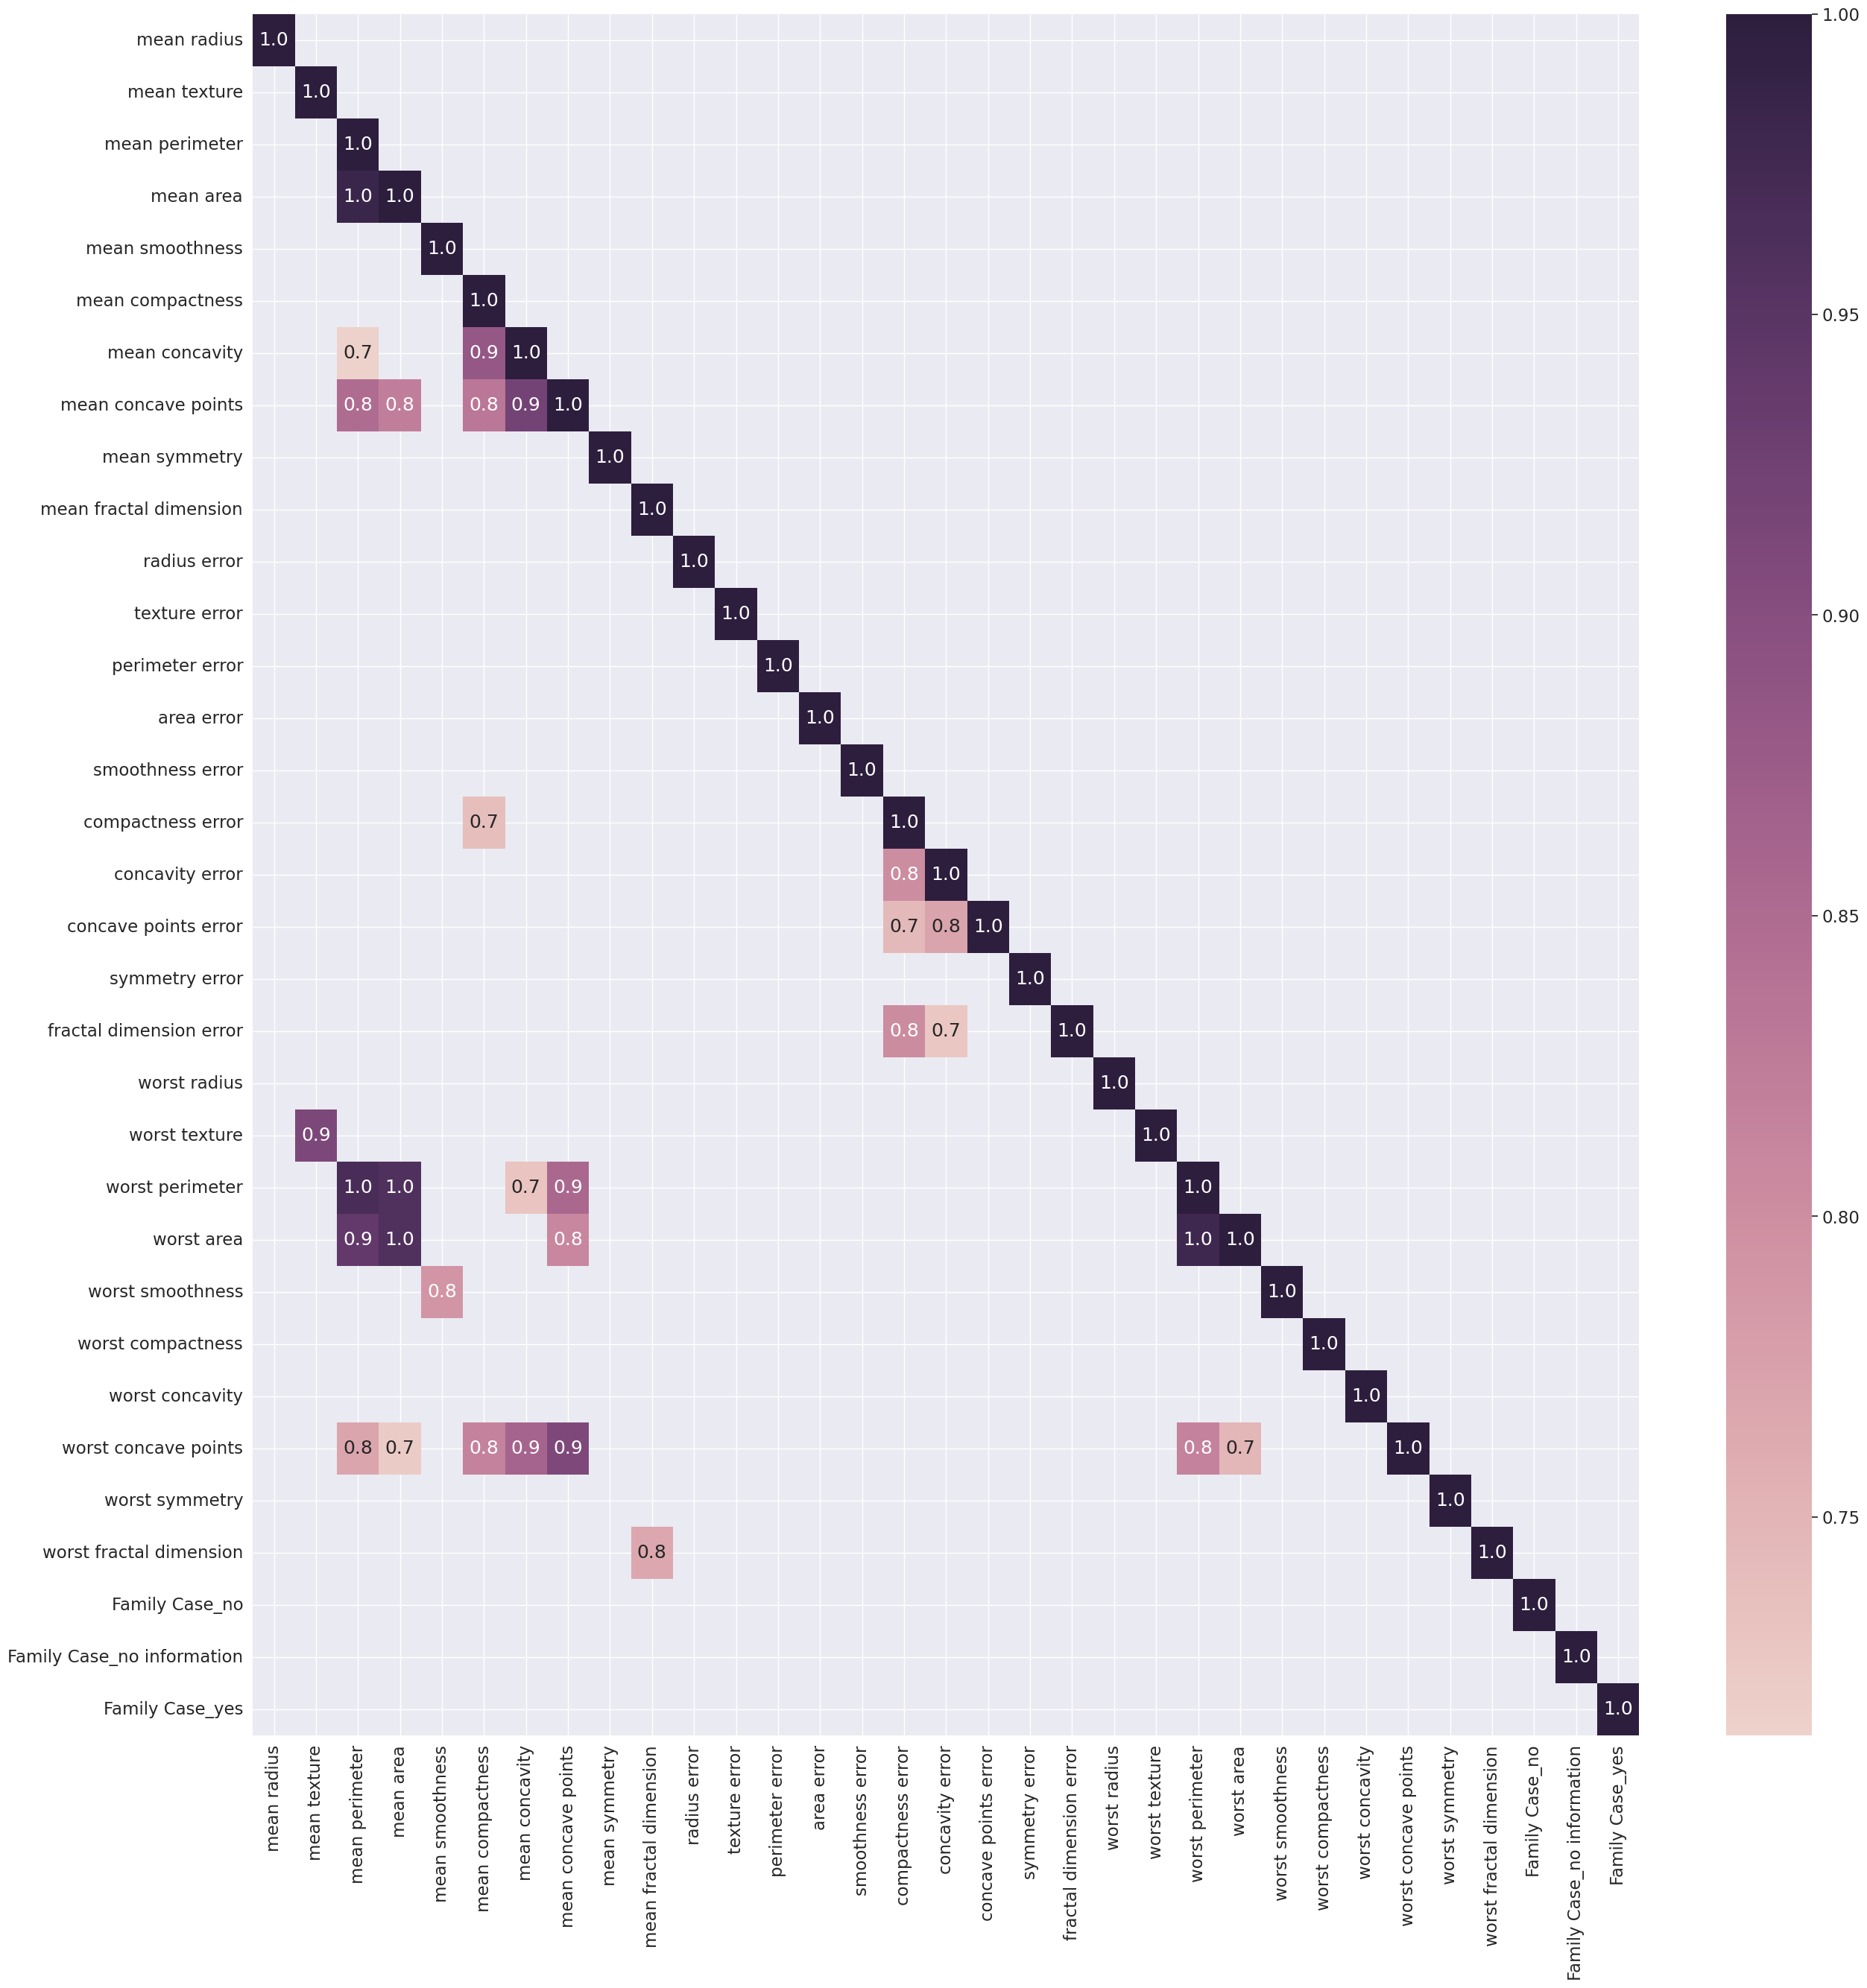

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mat[corr_mat > 0.7], annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200), mask=mask)

In [ ]:
def get_top_correlations_blog(df, threshold=-1):
    """
    df: the dataframe to get correlations from
    threshold: the maximum and minimum value to include for correlations. For eg, if this is -1.
    """
    orig_corr = df.corr()
    c = orig_corr.abs()

    so = c.unstack()

    #print("|    Variable 1    |    Variable 2    | Correlation Coefficient    |")
    #print("|------------------|------------------|----------------------------|")

    i=0
    pairs=set()
    result = pd.DataFrame()
    for index, value in so.sort_values(ascending=False).items():
        # Exclude duplicates and self-correlations
        if value > threshold \
        and index[0] != index[1] \
        and (index[0], index[1]) not in pairs \
        and (index[1], index[0]) not in pairs:

            #print(f'|    {index[0]}    |    {index[1]}    |    {orig_corr.loc[(index[0], index[1])]}    |')
            result.loc[i, ['Variable 1', 'Variable 2', 'Correlation Coefficient']] = [index[0], index[1], orig_corr.loc[(index[0], index[1])]]
            pairs.add((index[0], index[1]))
            i+=1
    return result.reset_index(drop=True).set_index(['Variable 1', 'Variable 2'])

get_top_correlations_blog(X_df)

,,Correlation Coefficient
Variable 1,Variable 2,
mean perimeter,mean area,0.98328
worst perimeter,worst area,0.977578
mean perimeter,worst perimeter,0.96835
worst area,mean area,0.959014
mean area,worst perimeter,0.958907
...,...,...
fractal dimension error,worst texture,-0.003195
Family Case_yes,mean smoothness,-0.002675
Family Case_no,smoothness error,0.002577


# Model Development and Results

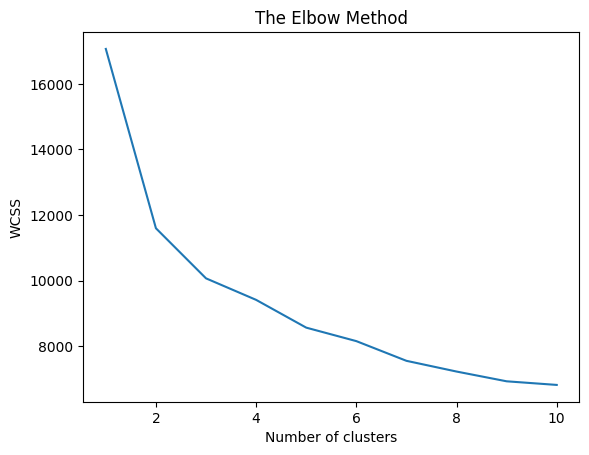

In [ ]:
#Finding the best number of cluster to my  data
num_cluster=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300)
    kmeans.fit(X)
    num_cluster.append(kmeans.inertia_)
plt.plot(range(1,11),num_cluster)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
pacientes_cluster=KMeans(n_clusters=2,init='k-means++',max_iter=300)
pacientes_cluster.fit(X)

KMeans(n_clusters=2)

In [ ]:
#Final Base
#X1 = min_max_scaler.inverse_transform(X)
df = pd.DataFrame(data=X, columns=Lista_variaveis)
df2 = pd.DataFrame(data=y,columns=['Tarq'])
df3 = pd.DataFrame(data=pacientes_cluster.labels_,columns=['Cluster'])
df = pd.concat([df,df2,df3],axis=1)
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Family Case_no,Family Case_no information,Family Case_yes,Tarq,Cluster
0,-0.285764,-2.075354,1.277861,0.985234,1.595487,3.283515,2.652874,2.532475,2.217515,2.255747,...,-0.032643,-0.052936,2.296076,2.750622,1.937015,-3.057034,-0.164547,3.636619,0,0
1,-0.284701,-0.354304,1.695130,1.909702,0.000000,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,-0.043454,-0.059668,1.087084,-0.243890,0.281190,-3.057034,-0.164547,3.636619,0,0
2,0.000000,0.456150,1.575320,1.559826,0.961343,1.052926,1.363478,2.037231,0.939685,-0.398008,...,-0.038084,-0.056679,1.955000,1.152255,0.201391,-3.057034,-0.164547,3.636619,0,0
3,-0.288470,0.000000,-0.590350,-0.763859,0.000000,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.028113,-0.053294,2.175786,6.046041,4.935010,-3.057034,-0.164547,3.636619,0,0
4,-0.284816,-1.153114,0.000000,1.827211,0.291168,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,-0.043039,-0.057400,0.729259,-0.868353,-0.397100,-3.057034,-0.164547,3.636619,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,-0.284293,0.721643,2.071086,2.344913,1.062230,0.219060,1.947285,2.320965,-0.312589,-0.931027,...,-0.042897,-0.057247,1.629151,-1.360158,-0.709091,-3.057034,6.077280,-0.274981,0,0
565,-0.284882,2.086373,1.624897,1.724808,0.111013,-0.017833,0.693043,1.263669,-0.217664,-1.058611,...,-0.043328,-0.058524,0.733827,-0.531855,-0.973978,-3.057034,6.077280,-0.274981,0,0
566,-0.286337,2.046782,0.678811,0.578752,-0.843806,-0.038680,0.046588,0.105777,-0.809117,-0.895587,...,-0.040682,-0.058255,0.414069,-1.104549,-0.318409,-3.057034,6.077280,-0.274981,0,0
567,-0.284689,2.337894,1.992590,1.736186,1.552250,3.272144,3.296944,2.658866,2.137194,1.043695,...,-0.028072,-0.049690,2.289985,1.919083,2.219635,-3.057034,6.077280,-0.274981,0,0


In [ ]:

pca=PCA(n_components=2)
pca.fit(df)
X_pca=pca.transform(df)
base=pd.DataFrame(data=X_pca,columns=['PC1','PC2'])
base['Cluster']=pacientes_cluster.labels_
base

,PC1,PC2,Cluster
0,8.510202,0.995539,0
1,2.011475,-3.007795,0
2,5.123830,-1.181884,0
3,7.661237,7.668979,0
4,2.980119,-0.904090,0
...,...,...,...
564,6.050064,-3.667663,0
565,3.462746,-3.602144,0
566,1.522636,-2.311440,0
567,9.533262,-0.188401,0


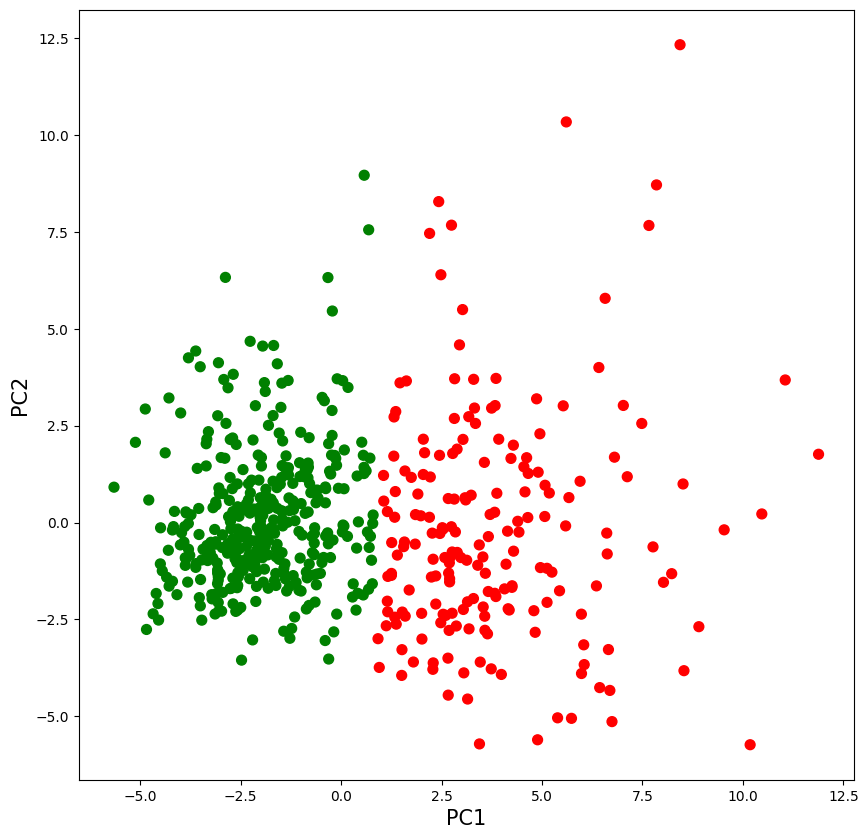

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.set_xlabel('PC1',fontsize=15)
ax.set_ylabel('PC2',fontsize=15)
color_theme = np.array(['red','green'])
ax.scatter(x=base['PC1'],y=base['PC2'],c=color_theme[base['Cluster']],s=50)

In [ ]:
print(pd.DataFrame(pca.components_,columns=df.columns,index = ['PC-1','PC-2']))
#in this case I observe the variables based on the correlation, that is, for a variable
#like PC2 in mean radius and mean texture the radius variable has more
#correlation with the PC2 component (inversely when the value is negative)

      mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
PC-1    -0.044637      0.117532        0.235825   0.225673         0.181487   
PC-2     0.233354     -0.093778       -0.267622  -0.271057         0.146871   

      mean compactness  mean concavity  mean concave points  mean symmetry  \
PC-1          0.285293        0.297608             0.293686       0.177583   
PC-2          0.095272        0.008180            -0.090973       0.164307   

      mean fractal dimension  ...  worst compactness  worst concavity  \
PC-1                0.107555  ...           0.033229         0.039547   
PC-2                0.369355  ...           0.072080         0.111604   

      worst concave points  worst symmetry  worst fractal dimension  \
PC-1              0.285180        0.154259                 0.174631   
PC-2             -0.081679        0.095297                 0.236960   

      Family Case_no  Family Case_no information  Family Case_yes      Tarq  \
PC-1       -0.

In [ ]:

print(pd.DataFrame(pca.explained_variance_ratio_.reshape(1, -1), columns=['PC-1', 'PC-2'], index=['Variance Explained']))


                        PC-1      PC-2
Variance Explained  0.304107  0.152083


In [ ]:
df_components = pd.DataFrame(pca.components_,columns=df.columns,index = ['PC-1','PC-2'])
print(df_components.abs().sum(axis=0))

mean radius                   0.277991
mean texture                  0.211310
mean perimeter                0.503447
mean area                     0.496730
mean smoothness               0.328358
mean compactness              0.380565
mean concavity                0.305787
mean concave points           0.384659
mean symmetry                 0.341890
mean fractal dimension        0.476910
radius error                  0.208779
texture error                 0.110743
perimeter error               0.277126
area error                    0.105910
smoothness error              0.285923
compactness error             0.423333
concavity error               0.376848
concave points error          0.331436
symmetry error                0.277305
fractal dimension error       0.432087
worst radius                  0.197942
worst texture                 0.211262
worst perimeter               0.502798
worst area                    0.492064
worst smoothness              0.297134
worst compactness        